#Mount Google Drive and install the right version of openCV

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!pip install opencv-python==3.3.0.10 opencv-contrib-python==3.3.0.10
exit()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
     |████████████████████████████████| 15.5MB 198kB/s 
     |████████████████████████████████| 21.4MB 76.9MB/s 
ERROR: dopamine-rl 1.0.5 has requirement opencv-python>=3.4.1.15, but you'll have opencv-python 3.3.0.10 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Su

#1. Frequency Domain Processing
One can see that the input image has lines flowing across it and these are due to the presence of periodic noise in the image. These periodic noises can be removed using a band reject or notch filters to filter out the specific range of frequencies that can filter out these periodic noises. 

\

The image is first converted into the frequency domain using FFT and then shifted to center the DC component of the image. Various band reject filters and notch filters were implemented as per their formulae and various values of the input parameters were experimented with. A desired kernel can be applied in the frequency domain by simply multiplying with the frequency transformed image. Once this is done, the image is converted back to time domain by performing inverse FFT and Inverse shifting. The image is then displayed. 

\
Since the two images provided have different kind of periodic noises, various kernels with different parameters were tried. For both of them, gaussian kernel with the parameters specified in the code yielded he best results. 

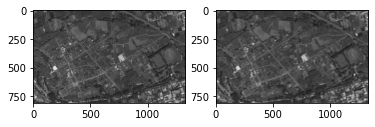

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import math
import matplotlib.pyplot as plt
from PIL import Image

def distance(x, y):
  d = (x[0] - y[0])**2 + (x[1] - y[1])**2
  d = math.sqrt(d)
  return d

def idealbandrej(D0, W, img):
  shape = img.shape
  kernel = np.ones(shape[:2])
  center = (shape[0]/2, shape[1]/2)
  for i in range(shape[0]):
    for j in range(shape[1]):
      d = distance((i,j),center)
      if d>=(D0 - (W/2)) and d<=(D0 + (W/2)):
        kernel[i,j] = 0
  return kernel

def butterbandrej(D0, W, n, img):
  shape = img.shape
  kernel = np.zeros(shape[:2])
  center = (shape[0]/2, shape[1]/2)
  for i in range(shape[0]):
    for j in range(shape[1]):
      d = distance((i,j), center)
      kernel[i,j] = 1/(1 + (((d*W)/(d**2 - D0**2))**(2*n)))
  return kernel

def gaussianbandrej(D0, W, img):
  shape = img.shape
  kernel = np.zeros(shape[:2])
  center = (shape[0]/2, shape[1]/2)
  for i in range(shape[0]):
    for j in range(shape[1]):
      d = distance((i,j), center)
      if d!=0:
        kernel[i, j] = 1 - math.exp((((d**2 - D0**2)/(d*W))**2)*-0.5)
      else:
        kernel[i,j] = 1
  return kernel

def idealnotch(D0, u0, v0, img):
  shape = img.shape
  kernel = np.ones(shape[:2])
  center = (shape[0]/2, shape[1]/2)
  for i in range(shape[0]):
    for j in range(shape[1]):
      d1 = ((i - center[0] - u0)**2 + (j - center[1] - v0)**2)**0.5
      d2 = ((i - center[0] + u0)**2 + (j - center[1] + v0)**2)**0.5
      if d1<=D0 or d2<=D0:
        kernel[i,j] = 0
  return kernel

def butternotch(D0, u0, v0, n, img):
  shape = img.shape
  kernel = np.zeros(shape[:2])
  center = (shape[0]/2, shape[1]/2)
  for i in range(shape[0]):
    for j in range(shape[1]):
      d1 = ((i - center[0] - u0)**2 + (j - center[1] - v0)**2)**0.5
      d2 = ((i - center[0] + u0)**2 + (j - center[1] + v0)**2)**0.5
      kernel[i, j] = 1 / (1 + ((D0**2/(d1 * d2))**n))
  return kernel

def gaussiannotch(D0, u0, v0, img):
  shape = img.shape
  kernel = np.zeros(shape[:2])
  center = (shape[0]/2, shape[1]/2)
  for i in range(shape[0]):
    for j in range(shape[1]):
      d1 = ((i - center[0] - u0)**2 + (j - center[1] - v0)**2)**0.5
      d2 = ((i - center[0] + u0)**2 + (j - center[1] + v0)**2)**0.5
      kernel[i, j] = 1 - math.exp(((d1 * d2)/(D0**2))*(-0.5))
  return kernel

img = Image.open('/content/gdrive/My Drive/periodic-noise1.png')
img2 = Image.open('/content/gdrive/My Drive/periodic-noise2.png')
freq = np.fft.fft2(img)
freq2 = np.fft.fft2(img2)
freq_shift = np.fft.fftshift(freq)
freq_shift2 = np.fft.fftshift(freq2)
kernel = gaussianbandrej(140, 30, freq_shift)
kernel2 = gaussianbandrej(70, 17, freq_shift2)
mul = np.multiply(freq_shift, kernel)
mul2 = np.multiply(freq_shift2, kernel2)
img_unshift = np.fft.ifftshift(mul)
img_unshift2 = np.fft.ifftshift(mul2)
img_filtered = np.fft.ifft2(img_unshift)
img_filtered2 = np.fft.ifft2(img_unshift2)
fig, (ax1, ax2) = plt.subplots(1, 2)
plt.gray()
ax1.imshow(abs(img_filtered))
ax2.imshow(abs(img_filtered2))

#2. Wavelet Domain Processing
The input image is first applied with a 2-level DWT using the pywt module. The coeffecients are obtained after this process. If we are dealing with a salt and pepper noise, a median filter is applied by basic convolution on each and every wavelet. This process is one of the most effective ways to remove salt and pepper noise from the image based on the paper: https://arxiv.org/ftp/arxiv/papers/1703/1703.06499.pdf
When a median blur is used, it removed the salt and pepper nooise, but the reusltinng image is blurred and also lost all its contrast. However, this can be corrected by histogram eqalization which is not the scope of this assignment. 

\
The remaining steps are the same for gaussian noise and the salt and pepper noise. Sigma_x is obtained by taking the median of the HH1 wavelet. After this, sigma_w is taken for each and every wavelet exccept LL2 based on the provided formula. Once this is done, the thresholding function provied by pywt is used to threshold each and every wavelet. Once this is done, the wavelets can again be combined to get the reconstructed image. 

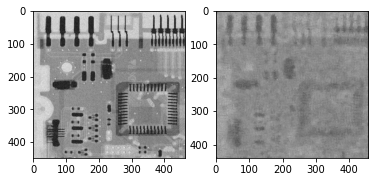

In [ ]:
import pywt
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import math
from scipy import signal

img = Image.open('/content/gdrive/My Drive/ckt-board-gauss-var-400.tif')
coeff = pywt.wavedec2(img, 'haar', level=2)
[LL2, (LH2, HL2, HH2), (LH1, HL1, HH1)] = coeff
sigma_x = np.median(np.abs(HH1))


sigma_w_LH2 = (np.mean(LH2**2) - sigma_x**2)
sigma_w_HL2 = (np.mean(HL2**2) - sigma_x**2)
sigma_w_HH2 = (np.mean(HH2**2) - sigma_x**2)
sigma_w_LH1 = (np.mean(LH1**2) - sigma_x**2)
sigma_w_HL1 = (np.mean(HL1**2) - sigma_x**2)
sigma_w_HH1 = (np.mean(HH1**2) - sigma_x**2)


if sigma_w_LH2<0:
  sigma_w_LH2 = 0
if sigma_w_HL2<0:
  sigma_w_HL2 = 0
if sigma_w_HH2<0:
  sigma_w_HH2 = 0
if sigma_w_LH1<0:
  sigma_w_LH1 = 0
if sigma_w_HL1<0:
  sigma_w_HL1 = 0
if sigma_w_HH1<0:
  sigma_w_HH1 = 0

sigma_w_LH2 = math.sqrt(sigma_w_LH2)
sigma_w_HL2 = math.sqrt(sigma_w_HL2)
sigma_w_HH2 = math.sqrt(sigma_w_HH2)
sigma_w_LH1 = math.sqrt(sigma_w_LH1)
sigma_w_HL1 = math.sqrt(sigma_w_HL1)
sigma_w_HH1 = math.sqrt(sigma_w_HH1)


del_sigma_w_LH2 = (sigma_x**2)/sigma_w_LH2
del_sigma_w_HL2 = (sigma_x**2)/sigma_w_HL2
del_sigma_w_HH2 = (sigma_x**2)/sigma_w_HH2
del_sigma_w_LH1 = (sigma_x**2)/sigma_w_LH1
del_sigma_w_HL1 = (sigma_x**2)/sigma_w_HL1
del_sigma_w_HH1 = (sigma_x**2)/sigma_w_HH1


new_LH2 = pywt.threshold(LH2, value=del_sigma_w_LH2, mode='soft')
new_HL2 = pywt.threshold(HL2, value=del_sigma_w_HL2, mode='soft')
new_HH2 = pywt.threshold(HH2, value=del_sigma_w_HH2, mode='soft')
new_LH1 = pywt.threshold(LH1, value=del_sigma_w_LH1, mode='soft')
new_HL1 = pywt.threshold(HL1, value=del_sigma_w_HL1, mode='soft')
new_HH1 = pywt.threshold(HH1, value=del_sigma_w_HH1, mode='soft')

new_coeffs = LL2, (new_LH2, new_HL2, new_HH2), (new_LH1, new_HL1, new_HH1)
filtered1 = pywt.waverec2(new_coeffs, 'haar')

img = Image.open('/content/gdrive/My Drive/ckt_saltpep_prob_pt25.tif')
coeff = pywt.wavedec2(img, 'haar', level=2)

coe = signal.medfilt(coeff[0], 3)
n_c = [coe]
for m in range(1,len(coeff)):
  d = signal.medfilt(coeff[m][0], 3)
  e = signal.medfilt(coeff[m][1], 3)
  f = signal.medfilt(coeff[m][2], 3)
  n_c = n_c + [[d,e,f]]
coeff = n_c
[LL2, (LH2, HL2, HH2), (LH1, HL1, HH1)] = coeff
sigma_x = np.median(np.abs(HH1))

sigma_w_LH2 = (np.mean(LH2**2) - sigma_x**2)
sigma_w_HL2 = (np.mean(HL2**2) - sigma_x**2)
sigma_w_HH2 = (np.mean(HH2**2) - sigma_x**2)
sigma_w_LH1 = (np.mean(LH1**2) - sigma_x**2)
sigma_w_HL1 = (np.mean(HL1**2) - sigma_x**2)
sigma_w_HH1 = (np.mean(HH1**2) - sigma_x**2)


if sigma_w_LH2<0:
  sigma_w_LH2 = 0
if sigma_w_HL2<0:
  sigma_w_HL2 = 0
if sigma_w_HH2<0:
  sigma_w_HH2 = 0
if sigma_w_LH1<0:
  sigma_w_LH1 = 0
if sigma_w_HL1<0:
  sigma_w_HL1 = 0
if sigma_w_HH1<0:
  sigma_w_HH1 = 0

sigma_w_LH2 = math.sqrt(sigma_w_LH2)
sigma_w_HL2 = math.sqrt(sigma_w_HL2)
sigma_w_HH2 = math.sqrt(sigma_w_HH2)
sigma_w_LH1 = math.sqrt(sigma_w_LH1)
sigma_w_HL1 = math.sqrt(sigma_w_HL1)
sigma_w_HH1 = math.sqrt(sigma_w_HH1)


del_sigma_w_LH2 = (sigma_x**2)/sigma_w_LH2
del_sigma_w_HL2 = (sigma_x**2)/sigma_w_HL2
del_sigma_w_HH2 = (sigma_x**2)/sigma_w_HH2
del_sigma_w_LH1 = (sigma_x**2)/sigma_w_LH1
del_sigma_w_HL1 = (sigma_x**2)/sigma_w_HL1
del_sigma_w_HH1 = (sigma_x**2)/sigma_w_HH1


new_LH2 = pywt.threshold(LH2, value=del_sigma_w_LH2, mode='soft')
new_HL2 = pywt.threshold(HL2, value=del_sigma_w_HL2, mode='soft')
new_HH2 = pywt.threshold(HH2, value=del_sigma_w_HH2, mode='soft')
new_LH1 = pywt.threshold(LH1, value=del_sigma_w_LH1, mode='soft')
new_HL1 = pywt.threshold(HL1, value=del_sigma_w_HL1, mode='soft')
new_HH1 = pywt.threshold(HH1, value=del_sigma_w_HH1, mode='soft')

new_coeffs = LL2, (new_LH2, new_HL2, new_HH2), (new_LH1, new_HL1, new_HH1)
filtered2 = pywt.waverec2(new_coeffs, 'haar')
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(filtered1)
ax2.imshow(filtered2)
plt.gray()

#3. Feature Extraction and Description
OpenCv helps in providiing the feature detection and descriptions using SIFT algorithm. Keypoints are the important feature points found out by SIFT and the descriptors are the 128 length feature vectors given for each corresponding points.

\
A KNN algorithm was used to find the corresponding points between both the images and to find a distance was set as threshold to compare the differences in features. Two neighbrs were used in order to comapre the two feature with the lowest and second lowest distance from one another. These matches are called good matches and are stored for computing the homography matrices in the next step

\
The homography matrix is found out based on the good matches from the previous steps. This matrix is essential to convert the image from one reference frame to another. This homography matrix is used to convert the input image into the reference frame of the reference image.

\
Once the input image is warped into the reference frame, the images are then alligned and overlayed on one another. We can see from the output image that when they are overlayed on one another, the corresponding points overlap and hence an image mosaic is created which covers all the parts of both images.

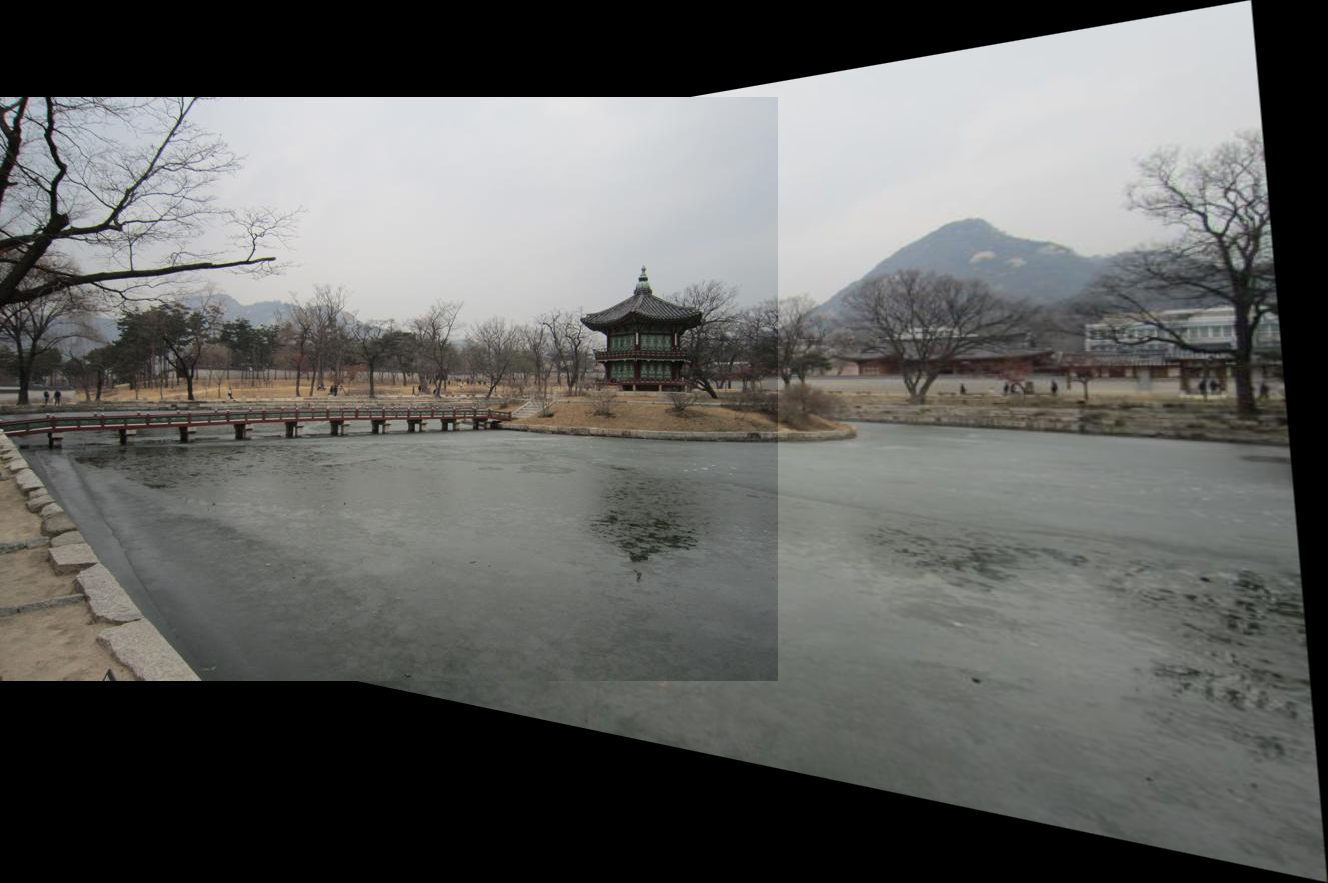

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import math
import matplotlib.pyplot as plt
from PIL import Image
from scipy.interpolate import interp2d

def feature_detection(img):
  sift = cv2.xfeatures2d.SIFT_create()
  keypoints = sift.detect(img)
  return keypoints


def feature_description(img):
  sift = cv2.xfeatures2d.SIFT_create()
  points, descriptor = sift.detectAndCompute(img, None)
  return points, descriptor


def feature_correspondence(des1, des2, kp1, kp2):
  FLANN_INDEX_KDTREE = 0
  i_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
  s_params = dict(checks = 50)
  match = cv2.FlannBasedMatcher(i_params, s_params)
  matches = match.knnMatch(des1,des2,k=2)
  good = []
  for m,n in matches:
    if m.distance < 0.5*n.distance:
      good.append(m)
  dst_points = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
  src_points = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)
  return src_points, dst_points


def homography_estimation(source_points, destination_points):
  M, mask = cv2.findHomography(source_points, destination_points)
  return M


def image_composition(img1, img2, H):
  h1,w1 = img1.shape[:2]
  h2,w2 = img2.shape[:2]
  pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
  pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
  pts2_ = cv2.perspectiveTransform(pts2, H)
  pts = np.concatenate((pts1, pts2_), axis=0)
  [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
  [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
  t = [-xmin,-ymin]
  Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]])
  result = cv2.warpPerspective(img2, Ht.dot(H), (xmax-xmin, ymax-ymin), borderMode = 0)
  img1_copy = np.zeros_like(result)
  result[t[1]:h1+t[1],t[0]:w1+t[0]] = img1 
  return result


img_ = cv2.imread('/content/gdrive/My Drive/seoul1.jpg')
img1 = cv2.cvtColor(img_,cv2.COLOR_BGR2GRAY)
img = cv2.imread('/content/gdrive/My Drive/seoul2.jpg')
img2 = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
kp1, des1 = feature_description(img1)
kp2, des2 = feature_description(img2)
src_pts, dst_pts = feature_correspondence(des1, des2, kp1, kp2)
H = homography_estimation(src_pts, dst_pts)
result = image_composition(img_, img, H)
cv2_imshow(result)